**[ResNet50을 이용한 의료영상 분석]**

* 과제명: 간에 다룬 Skin Cancer 데이터셋 HAM 10000에 대해 ResNet50을 이용해 분석(분류)하여라.

*코드 작성 내용*
1. 데이터 불균형을 위한 Oversampling 등 데이터 증강
2. ResNet50을 이용한 HAM10000 데이터 분류
3. Test data 중 1개의 결과에 대해 CAM 그리기

**<1. 데이터 불균형을 위한 Oversampling 등 데이터 증강>**

In [1]:
#기본 모듈들 import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#EDA

#HAM10000데이터셋 불러오기
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


*7가지 질환들*
* akiec: 광선각화증 및 상피내암종(Actinic keratoses and intraepithelial carcinoma)
* bcc: 기저세포암종(basal cell carcinoma)
* bkl: 양성 각화증 유사 병변(benign keratosis-like lesions)
* df: 피부섬유종(dermatofibroma)
* mel: 흑색종(mel)
* nv: 멜라닌 세포 모반(melanocytic nevi)
* vasc: 혈관 병변(vascular lesion)


Text(0.5, 1.0, 'Frequency Distribution of Classes')

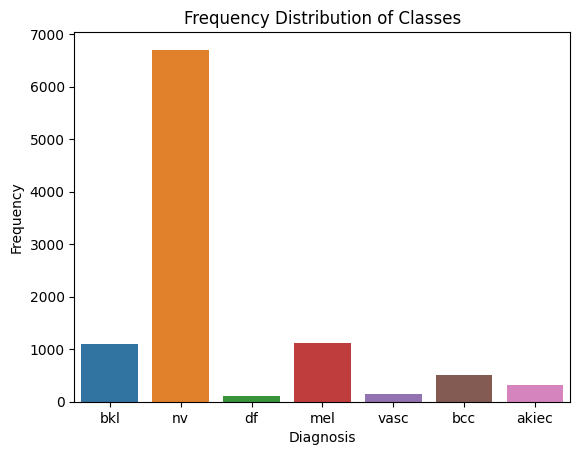

In [3]:
#7가지 질환들의 데이터셋이 각각 몇 개 있는지 확인
sns.countplot(x='dx', data=data)
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Classes')

==> 데이터양은 nv가 압도적으로 많고, df와 vasc는 극히 적음, 나머지는 유사

Text(0.5, 1.0, 'Frequency Distribution of Gender')

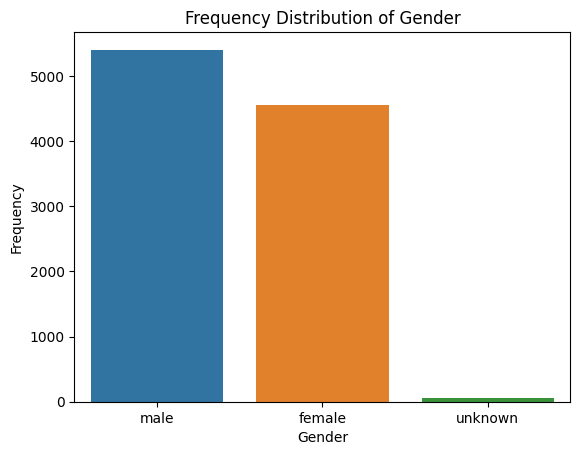

In [4]:
#성별별 피부암 발생 정도 확인
sns.countplot(x='sex', data=data)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Gender')

==> 남자에서 피부암 발병 정도가 좀 더 잦음

Text(0.5, 1.0, 'Frequency Distribution of Ages')

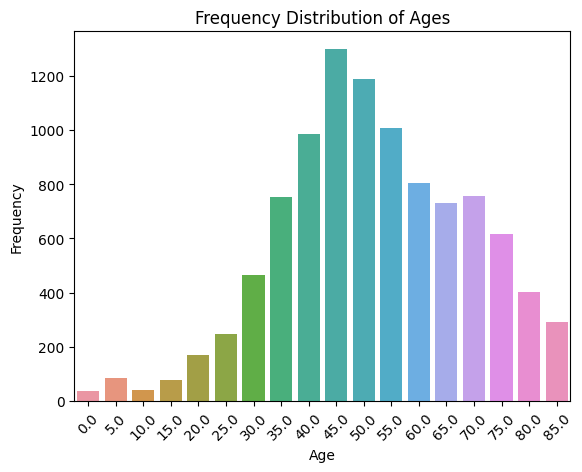

In [5]:
#나이별 피부암 발병 정도 히스토그램
sns.countplot(x='age', data=data)
plt.xticks(rotation=45) #레이블이 45도 각도로 회전되어 표시되게 하는 것
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Ages')

==> '나이'별로 히스토그램을 그렸을 때 "정규분포" 비슷하게 따름을 확인할 수 있었고, 30대에서 50대 사이에 피부암이 많이 발병함을 알 수 있음

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

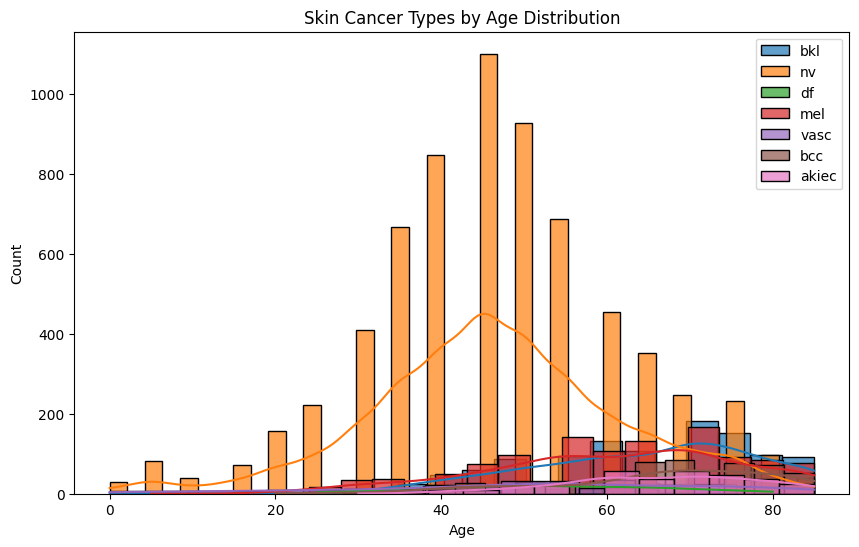

In [6]:
# Data Imbalance 확인: 피부암 질환별 연령 분포 시각화

# 피부암 질환 목록 확인
skin_cancers = data['dx'].unique()

plt.figure(figsize=(10, 6))
for cancer in skin_cancers:
    ages = data[data['dx'] == cancer]['age']
    sns.histplot(ages, kde=True, label=cancer, alpha=0.7) #KDE는 주어진 데이터의 분포를 부드럽게 표현하는 방법 중 하나로, 히스토그램의 형태를 보다 부드럽고 연속적인 곡선으로 나타내는 기법
                                            #투명도는 0.7정도로 조절

plt.title('Skin Cancer Types by Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()

==> 데이터양 자체가 압도적으로 많은 nv의 경우, 발병정도가 정규분포 모양을 하고 있는데, 데이터양이 적은 나머지 질환들은 고령층에서 집중적으로 발병하고 있음을 확인할 수 있다. 오른쪽으로 치우쳐 왼쪽으로 긴꼬리를 형성하고 있다(왜도값: 큰 음수값)

> 그냥 '나이별 피부암(전체) 발병 정도'를 보았을 때는 정규분포를 띠고 있지만, 위와 같이 각 질환별로 나눠보았을 때 데이터양이 압도적으로 많은 한 질병에 대해서만 정규분포를 띠고 나머지 질환은 고령층에 극히 치우쳐있다. 따라서 전자 그래프에서 nv의 경향을 따라 정규분포를 띠는 건 전체 데이터에서 nv데이터가 차지하는 비중이 매우 크기 때문이다. 
>> ==> **데이터 자체가 한쪽에 치우쳐있으므로, 정확하고 유의미한 분석을 위해 우선 Data Imbalance 문제를 해결해줄 필요가 있다!**

In [7]:
#HAM10000데이터셋 shape 살피기
data_img = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
print('shape: ', data_img.shape)
print('column names: ', data_img.columns)

shape:  (10015, 2353)
column names:  Index(['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004',
       'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009',
       ...
       'pixel2343', 'pixel2344', 'pixel2345', 'pixel2346', 'pixel2347',
       'pixel2348', 'pixel2349', 'pixel2350', 'pixel2351', 'label'],
      dtype='object', length=2353)


==> 10015개의 데이터와 2353개의 변수들로 구성돼있다.

*모델 학습에 대해선 데이터가 많을수록 좋으니까 under-sampling 대신, minority 데이터를 늘리는 over-sampling을 적용해본다*

Shape of X:  (46935, 28, 28, 3)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Frequency Distribution of Classes')

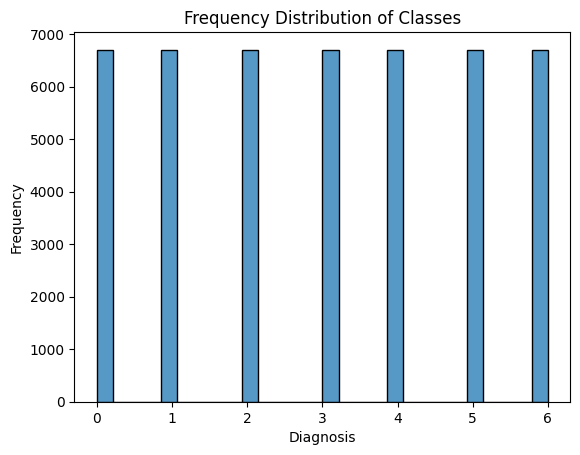

In [8]:
#데이터 불균형(Data Imbalance) 헤소를 위한, Over-sampling 적용

#moniority dataset에 대해 Oversampling 진행하기
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler() #oversample 객체 생성

X_over = data_img.drop(columns=['label'])
Y_over = data_img['label']

X_over, Y_over = oversample.fit_resample(X_over, Y_over) #oversample 객체에 fitting 시켜준 후, X_over&Y_over에 대해 oversampling 진행

X_over = np.array(X_over).reshape(-1, 28, 28, 3) #(배열의 전체 길이, 전체 행크기, 전체 열크기, 채널 수) 
                                #배열의 전체길이가 '-1'인 경우: 원래 배열 길이에 따라 자동으로 계산됨
print('Shape of X: ', X_over.shape)

sns.histplot(Y_over)
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Classes')

==> 데이터 전체 샘플 수는 46,935개, 28x28 크기에, 3개의 채널을 갖는다
> df reshape: reshape 전에는 10,015개의 이미지 데이터를 지니고 있었는데, Over-sampling 후 거의 47,000개 정도로 전체 데이터가 증가

==> Class에 대한 분포확인 결과: 불균형이 심했던 데이터들이 oversampling 후 균등하게 분포되어있음을 확인 가능

+) 이미지 증강(Argumentation)과 Over-sampling의 차이?
1. 이미지 증강 (Image Augmentation):

* 이미지 증강은 기존의 데이터를 변형하여 새로운 데이터를 생성하는 기술입니다. 주로 훈련 데이터를 더 다양하게 만들고, 모델의 일반화 성능을 향상시키는 데 사용됩니다.
* 이미지 증강은 이미지를 회전, 이동, 확대/축소, 반전, 밝기 조절 등의 다양한 방법으로 변형하여 새로운 훈련 데이터를 생성합니다.
* 주로 컴퓨터 비전 분야에서 사용되며, 데이터셋이 작거나 다양성을 확보해야 할 때 유용합니다.
2. 오버샘플링 (Oversampling):
* 오버샘플링은 특정 클래스의 데이터를 복제하거나, 새로운 데이터를 합성하여 클래스 간의 불균형을 해소하는 방법입니다.
* 주로 클래스 분포가 불균형한 경우에 사용됩니다. 예를 들어, 양성 클래스의 데이터가 부족한 경우, 오버샘플링을 통해 양성 클래스 데이터를 증가시켜 모델이 더 잘 학습하도록 돕습니다.
* 오버샘플링은 단순 반복 복제, 합성 소수 데이터 생성 (예: SMOTE, ADASYN) 등의 방법으로 수행됩니다.
>요약하면, 이미지 증강은 기존 데이터를 변형하여 다양성을 높이는 방법이고, 오버샘플링은 특정 클래스의 데이터를 증가시켜 데이터의 불균형을 해소하는 방법입니다.

In [9]:
#train_test_data split
from sklearn.model_selection import train_test_split
    #증강한 데이터셋을 train과 test로 나눔
X_train, X_test, Y_train, Y_test = train_test_split(X_over, Y_over, test_size=0.2, random_state=2023)

In [10]:
#output을 7개로 분할해주기 위해, label에 대해 one-hot encoding을 진행
from keras.utils import to_categorical

# 타겟 데이터를 원-핫 인코딩
Y_train_encoded = to_categorical(Y_train, num_classes=10)
Y_test_encoded = to_categorical(Y_test, num_classes=10)

# 모델의 출력층의 뉴런 수를 클래스 수에 맞게 설정
# 예를 들어, Dense(10, activation='softmax')와 같이 설정

2024-05-13 06:15:27.943930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 06:15:27.944029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 06:15:28.082510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**<2. ResNet50을 이용한 HAM10000 데이터 분류>**

*우선, keras에 내장된 ResNet function을 통해 간단하게 구현본다*

In [11]:
#모델 생성 및 학습을 위한 기본 모듈 불러오기
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [12]:
from tensorflow.keras.applications import ResNet50

IMAGE_SIZE = 28
BATCH_SIZE = 64

def model_resnet50(in_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=10): #224
    input_tensor = Input(shape=in_shape)
    
    base_model = ResNet50(input_tensor=input_tensor, include_top=False, weights='imagenet') #imagenet으로 학습된 parameter들이 모델 생성 시 초기값으로 활용되어지게 됨
    bm_output = base_model.output
    
    x = GlobalAveragePooling2D()(bm_output) #model의 output(bm_output)를 fully-connected에 연결
    x = Dense(50, activation='relu', name='fc1')(x)
    output = Dense(n_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model

In [13]:
model1 = model_resnet50(in_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=10)

model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model1.fit(X_train, Y_train_encoded, validation_split=0.2, batch_size=128, epochs=100, shuffle=True, callbacks=[rlr_cb, ely_cb])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 34, 34, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 14, 14,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 14, 14,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 14, 14,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 16, 16,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 7, 7, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 7, 7, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 7, 7, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 7, 7, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 7, 7, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 7, 7, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 7, 7, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 7, 7, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 7, 7, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,690,672 (90.37 MB)

 Trainable params: 23,637,552 (90.17 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/100
  2/235 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.1387 - loss: 3.4398   

I0000 00:00:1715581004.012192      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715581004.102474      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5754 - loss: 1.3558

W0000 00:00:1715581044.016075      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


235/235 ━━━━━━━━━━━━━━━━━━━━ 104s 182ms/step - accuracy: 0.5762 - loss: 1.3532 - val_accuracy: 0.8328 - val_loss: 0.5638 - learning_rate: 1.0000e-04
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9540 - loss: 0.1478 - val_accuracy: 0.9570 - val_loss: 0.1301 - learning_rate: 1.0000e-04
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9808 - loss: 0.0643 - val_accuracy: 0.9680 - val_loss: 0.1023 - learning_rate: 1.0000e-04
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9813 - loss: 0.0619 - val_accuracy: 0.9704 - val_loss: 0.0988 - learning_rate: 1.0000e-04
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9892 - loss: 0.0377 - val_accuracy: 0.9511 - val_loss: 0.1504 - learning_rate: 1.0000e-04
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9863 - loss: 0.0451 - val_accuracy: 0.9518 - val_loss: 0.1585 - learning_rate: 1.0000e-04
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step -

294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
Accuracy :  0.9847661659742196
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00      1343
           1       0.99      1.00      1.00      1365
           2       0.96      0.99      0.98      1342
           3       1.00      1.00      1.00      1305
           4       0.99      0.90      0.94      1273
           5       1.00      1.00      1.00      1401
           6       0.95      0.99      0.97      1358

    accuracy                           0.98      9387
   macro avg       0.99      0.98      0.98      9387
weighted avg       0.99      0.98      0.98      9387



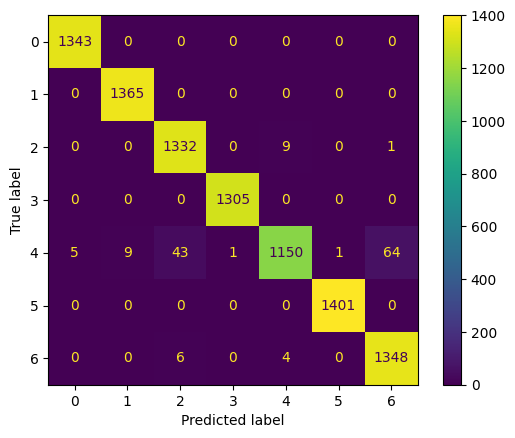

In [14]:
#test data를 이용해 예측하기
y_pred = model1.predict(X_test)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_test_labels = []
for i in Y_test_encoded:
    y_test_labels.append(np.argmax(i))
    
#sklearn 내 다른 지표들도 살펴보기
from sklearn import metrics

print("Accuracy : ", metrics.accuracy_score(y_test_labels, y_pred_labels)) #Evaluating predictions with test labels
print("Report : ", metrics.classification_report(y_test_labels, y_pred_labels))
    #정확도뿐 아니라, precision, recall, f1-score에 대해서도 살펴봄

confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

*다음으로, ResNet50모델을 직접 구현해본다*

In [15]:
#ResNet50은 총 50개의 layer를 가지고 있으며, 각각의 conv청크에 있는 []가 residual block임. 
    #layer마다 다른 residual block 형태가 반복되어 학습되는 과정을 거침
from tensorflow.keras.layers import Activation, ReLU, Add, AveragePooling2D
    
def residual_block(x, filters, stride=1):
    shortcut = x
    
    # 첫 번째 블록
    x = Conv2D(filters[0], kernel_size=1, strides=stride, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # 두 번째 블록
    x = Conv2D(filters[1], kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # 세 번째 블록
    x = Conv2D(filters[2], kernel_size=1, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    
    # 스트라이드가 1보다 클 경우 입력의 크기를 조정해 줌
    if stride != 1 or shortcut.shape[-1] != filters[2]: #shortcut의 형태(shape) 조정
        shortcut = Conv2D(filters[2], kernel_size=1, strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # shortcut과 합치기
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

def ResNet50_layer4(num_classes=10):
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    inputs = Input(shape=input_shape)
    
    # Layer 1
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Layer 2
    x = residual_block(x, filters=[64, 64, 256], stride=1)
    x = residual_block(x, filters=[64, 64, 256], stride=1)
    x = residual_block(x, filters=[64, 64, 256], stride=1)
    
    # Layer 3
    x = residual_block(x, filters=[128, 128, 512], stride=2)
    x = residual_block(x, filters=[128, 128, 512], stride=1)
    x = residual_block(x, filters=[128, 128, 512], stride=1)
    x = residual_block(x, filters=[128, 128, 512], stride=1)
    
    # Layer 4
    x = residual_block(x, filters=[256, 256, 1024], stride=2)
    x = residual_block(x, filters=[256, 256, 1024], stride=1)
    x = residual_block(x, filters=[256, 256, 1024], stride=1)
    x = residual_block(x, filters=[256, 256, 1024], stride=1)
    x = residual_block(x, filters=[256, 256, 1024], stride=1)
    x = residual_block(x, filters=[256, 256, 1024], stride=1)
    
    # Layer 5
    x = residual_block(x, filters=[512, 512, 2048], stride=2)
    x = residual_block(x, filters=[512, 512, 2048], stride=1)
    x = residual_block(x, filters=[512, 512, 2048], stride=1)
    
    # 평균 풀링
    x = AveragePooling2D(pool_size=(1,1), strides=(1,1))(x)
    
    # 완전 연결 레이어
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # 모델 생성
    model2 = Model(inputs=inputs, outputs=outputs, name='ResNet50_layer4')
    return model2

# ResNet50_layer4 모델 생성
model2 = ResNet50_layer4()
model2.summary()

##(pytorch로 직접구현한 ResNet50코드는 다음을 참고)##

Model: "ResNet50_layer4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 14,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 7, 7, 64)  │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │      4,160 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 64)  │     36,928 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 256) │     16,640 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 256) │     16,640 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 7, 7, 256) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 64)  │     16,448 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
#모델 생성 및 학습
model2 = ResNet50_layer4(num_classes=10)

model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model1.fit(X_train, Y_train_encoded, validation_split=0.2, batch_size=128, epochs=100, shuffle=True, callbacks=[rlr_cb, ely_cb])

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9999 - loss: 7.2755e-04 - val_accuracy: 0.9851 - val_loss: 0.0773 - learning_rate: 4.0000e-06
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9999 - loss: 4.8235e-04 - val_accuracy: 0.9852 - val_loss: 0.0764 - learning_rate: 4.0000e-06
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 1.0000 - loss: 2.9417e-04 - val_accuracy: 0.9855 - val_loss: 0.0762 - learning_rate: 4.0000e-06
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 1.0000 - loss: 2.9116e-04 - val_accuracy: 0.9855 - val_loss: 0.0761 - learning_rate: 4.0000e-06
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 1.0000 - loss: 3.8069e-04 - val_accuracy: 0.9851 - val_loss: 0.0767 - learning_rate: 4.0000e-06
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9999 - loss: 3.2610e-04 - val_accuracy: 0.9855 - val_loss: 0.0750 - learning_rate: 4.0000e-06
Epoch 7/100
235/235 ━━

294/294 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step
Accuracy :  0.13454777884308086
Report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00      1343
           1       0.00      0.00      0.00      1365
           2       0.00      0.00      0.00      1342
           3       0.00      0.00      0.00      1305
           4       0.13      0.94      0.24      1273
           5       0.00      0.00      0.00      1401
           6       0.13      0.05      0.07      1358

    accuracy                           0.13      9387
   macro avg       0.04      0.14      0.04      9387
weighted avg       0.04      0.13      0.04      9387



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


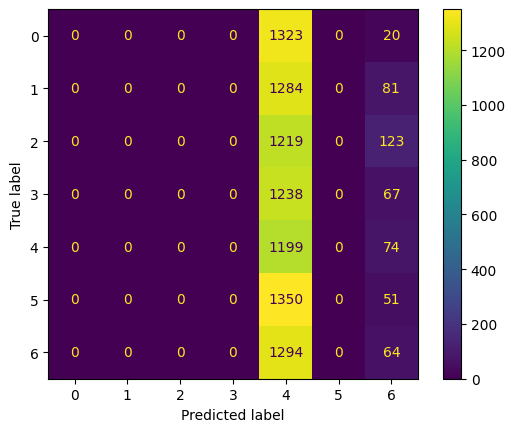

In [17]:
#test data를 이용해 예측하기
y_pred_2 = model2.predict(X_test)
y_pred_labels_2 = []
for i in y_pred_2:
    y_pred_labels_2.append(np.argmax(i))
y_test_labels = []
for i in Y_test_encoded:
    y_test_labels.append(np.argmax(i))

print("Accuracy : ", metrics.accuracy_score(y_test_labels, y_pred_labels_2)) #Evaluating predictions with test labels
print("Report : ", metrics.classification_report(y_test_labels, y_pred_labels_2))
    #정확도뿐 아니라, precision, recall, f1-score에 대해서도 살펴봄

confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels_2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

==> 직접 구현해보았는데, keras 내 내장된 ResNet50모델과 정확도가 너무 많이 차이가 난다: 단순구현 98% vs 직접구현 13%

**<3. Test data 중 1개의 결과에 대해 CAM 그리기>**

In [18]:
# 앞서만든 간단 구현 ResNet에서 CAM을 찍어보는 코드 작성: model1(keras 내장 ResNet50)에 대해 적용
cam_model = Model(inputs=model1.input, outputs=(model1.layers[-3].output, model1.layers[-1].output))
cam_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 34, 34, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 14, 14,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 14, 14,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 14, 14,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 16, 16,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 7, 7, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 7, 7, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 7, 7, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 7, 7, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 7, 7, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 7, 7, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 7, 7, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 7, 7, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 7, 7, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,690,672 (90.37 MB)

 Trainable params: 23,637,552 (90.17 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [19]:
#CAM을 찍을 수 있는 function 생성
import tensorflow as tf
import scipy as sp

def show_cam(image_value, features, results, model1):
    features_for_img = features[0]  # Assuming only one image in the batch
    prediction = tf.argmax(results)  # Get the predicted class
    gap_layer = None

    # Find the GlobalAveragePooling2D layer in the model
    for layer in model1.layers[::-1]:
        if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
            gap_layer = layer
            break

    if gap_layer is None:
        raise ValueError("GlobalAveragePooling2D layer not found in the model.")

    # Get the output shape of the GlobalAveragePooling2D layer
    output_shape = tf.keras.backend.int_shape(gap_layer.output)

    if len(output_shape) == 1:  # Handle case where output_shape is (height,)
        height = output_shape[0]  # Use the single value as height
        width, channels = 1, 1  # Set width and channels to 1
    else:
        height = output_shape[1] if len(output_shape) > 1 else 1
        width = output_shape[2] if len(output_shape) > 2 else 1
        channels = output_shape[3] if len(output_shape) > 3 else 1

    # Reshape features_for_img into appropriate shape
    features_for_img = features_for_img.reshape((height, 1))

    # Upsample the features_for_img to match the target size
    target_height = image_value.shape[0]
    target_width = image_value.shape[1]
    class_activation_features = sp.ndimage.zoom(features_for_img, (target_height / height, 1), order=2)

    # Get the weights connected to the predicted class
    gap_weights = model1.layers[-1].get_weights()[0]
    class_activation_weights = gap_weights[:, prediction]

    # Reshape class_activation_weights to (1, 500) if needed
    class_activation_weights = class_activation_weights.reshape((1, -1))

    # Compute the intensity of each feature in the CAM
    cam_output = np.dot(class_activation_features, class_activation_weights)

    # Visualize the results
    plt.figure(figsize=(8, 8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

In [20]:
#ResNet에서 일반적으로 입력 이미지를 표준화(Standardization)하는게 일반적.
    #입력이미지에서 평균을 빼고 표준편차로 나누는 전처리 수행 가능
from tensorflow.keras.applications.resnet import preprocess_input

#이미지 데이터 불러오기
img = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
img = img.drop(columns = ['label'])

#이미지 전처리
test_img = np.array(img.loc[0]) #test image를 가져와서 
test_img = test_img.reshape(28,28,3) #28x28, 3channels로 만듦 #원본 그 자체를 가지고 있다가 나중에 show_cam으로 불러올 때 이미지를 이쪽에 불러오게 됨

#이미지 크기 조정
test_img = sp.ndimage.zoom(test_img, (IMAGE_SIZE/28, IMAGE_SIZE/28, 1))
test_img = test_img.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)

#이미지 전처리 수행
test_img_proc = preprocess_input(test_img) / 255

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


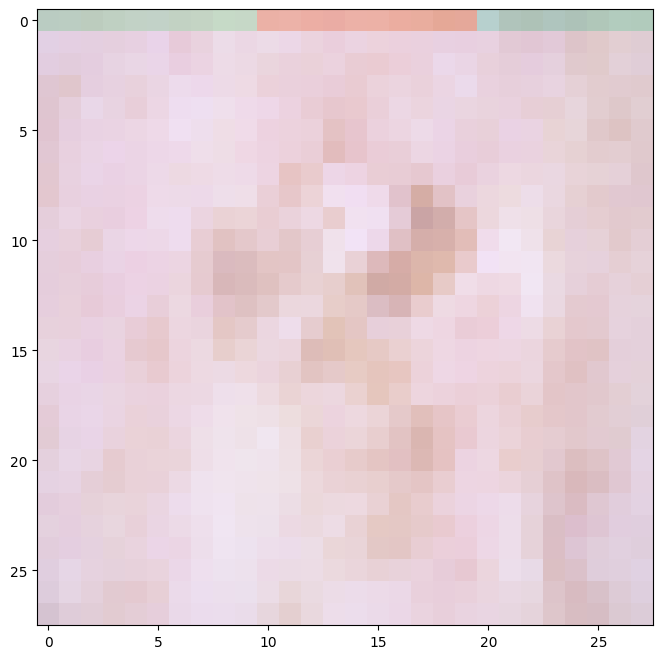

In [21]:
#cam_input = np.expand_dims(test_img_proc, axis=0)
features, results = cam_model.predict(test_img_proc) #preprocessing해준 것들을 CAM model에 들어가는 feature map과 예측결과를 넘겨서 활용해준다

show_cam(test_img, features, results, cam_model)

==> original 이미지 위에 불투명한 색 이미지가 덧대어진 채로 나와야 하는데, 맨 윗 부분에서 잘린듯하다. 그래도 보면, 해당 이미지에서는 모델이 특히 가운데 윗쪽 부분을 보고 피부암을 예측함을 유추할 수 있다.

In [22]:
print(features.shape)

(1, 2048)


In [23]:
w_out = model1.layers[-1].get_weights()[0]
print(w_out.shape)

(50, 10)
